# Inspiration

- Basic Keras implementation: https://www.kaggle.com/bguberfain/naive-keras

- High-level image segmentation example: https://medium.com/nanonets/how-to-do-image-segmentation-using-deep-learning-c673cc5862ef

- UNet original paper: https://arxiv.org/pdf/1505.04597.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
from os.path import join
from tqdm import tqdm_notebook
import cv2
from sklearn.model_selection import train_test_split

# Data loading & processing

In [2]:
input_folder = join('input')
imgs_idx = list(range(1, 17))

df_mask_train = pd.read_csv(join(input_folder, 'train_masks.csv'), usecols=['img'])
ids_train = df_mask_train['img'].map(lambda s: s.split('_')[0]).unique()
print("There are %d unique images and %d unique cars in the train set" % (len(df_mask_train),len(ids_train)))


df_mask_test = pd.read_csv(join(input_folder, 'sample_submission.csv'), usecols=['img'])
ids_test = df_mask_test['img'].map(lambda s: s.split('_')[0]).unique()
print("There are %d unique images and %d unique cars in the test set" % (len(df_mask_test),len(ids_test)))

There are 5088 unique images and 318 unique cars in the train set
There are 100064 unique images and 6254 unique cars in the test set


In [3]:
load_img = lambda im, idx: imread(join(input_folder, 'train/test', '{}_{:02d}.jpg'.format(im, idx)))
load_mask = lambda im, idx: imread(join(input_folder, 'train_masks', '{}_{:02d}_mask.gif'.format(im, idx)))
load_test_img = lambda im, idx: imread(join(input_folder, 'test/test', '{}_{:02d}.jpg'.format(im, idx)))

# Changing image dimensions from 1280x1918 -> 1280x1920 -> 320x480
def downscale(im):
    im = cv2.copyMakeBorder(im,0,0,1,1,cv2.BORDER_REPLICATE)
    return cv2.resize(im, (0,0), fx=0.25, fy=0.25)

# Changing image dimensions from 320x480 -> 1280x1920 -> 1280x1918
def upscale(im):
    im = cv2.resize(im, (0,0), fx=4, fy=4)
    return im[:,1:-1]

IMG_HEIGHT, IMG_WIDTH = load_img(ids_train[0], 1).shape[:2]
SCALE_FACTOR = 4

print("Dimension of each train image is", load_img(ids_train[0], 1).shape)
print("Dimension of each test image is", load_test_img(ids_test[0], 1).shape)

Dimension of each train image is (1280, 1918, 3)
Dimension of each test image is (1280, 1918, 3)


Text(0.5,1,'Mask')

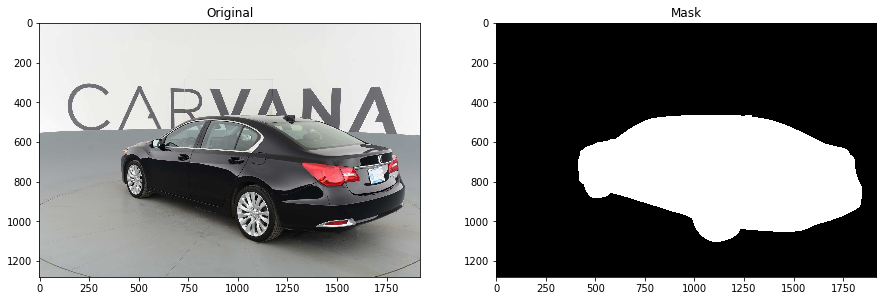

In [11]:
# Let's display a single car and mask

fig, ax = plt.subplots(1,2, figsize=(15, 10))
ax = ax.ravel()

ax[-2].imshow(load_img(ids_train[0], 7))
ax[-2].set_title('Original')
ax[-1].imshow(load_mask(ids_train[0], 7), cmap = 'Greys_r')
ax[-1].set_title('Mask')

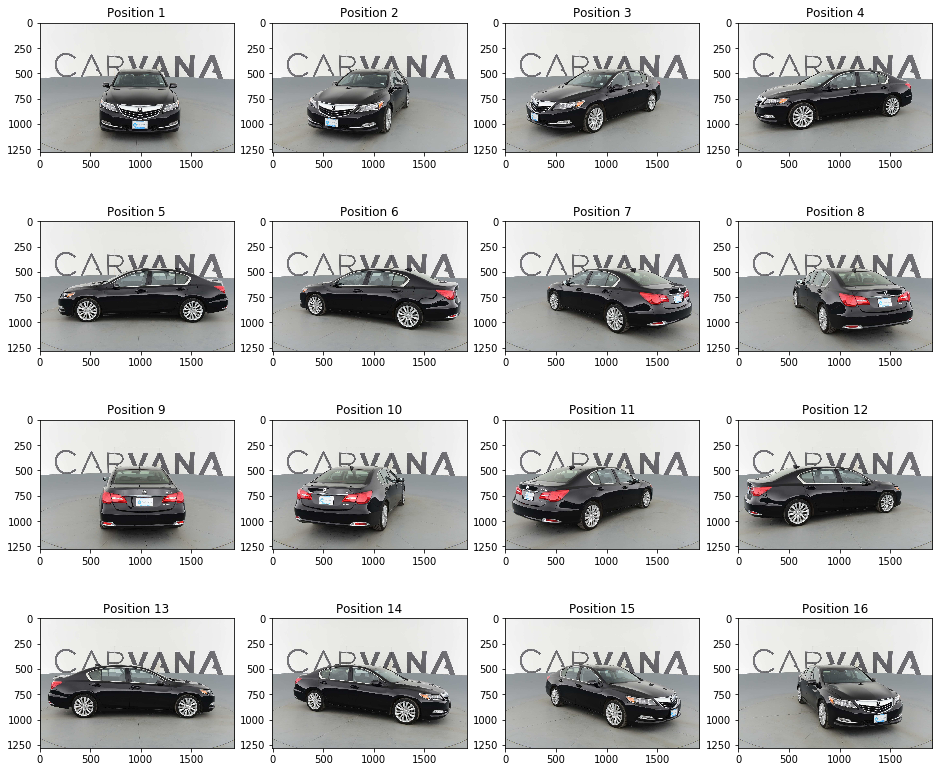

In [8]:
# Let's display a car in all orientations

fig, ax = plt.subplots(4,4, figsize=(16, 14))
ax = ax.ravel()

for i in imgs_idx:
    ax[i-1].imshow(load_img(ids_train[0], i))
    #ax[i-1].imshow(load_mask(ids_train[0], i), alpha = 0.5, cmap = 'Greys_r')
    ax[i-1].set_title('Position {}'.format(i))

Seems like there is a lot of rotational symmetry e.g. #2 and #17, although the pictures are not exact copies of each other (you can see from the background text)

In [12]:
# Preprocessing - loading all the training images, downscaling and concatenating into one 4D array

num_train = len(ids_train)

X = np.empty((num_train*16, 320, 480, 3), dtype=np.float32)
y = np.empty((num_train*16, 320, 480, 1), dtype=np.float32)

with tqdm_notebook(total=num_train*16) as bar:
    idx = 1 # Rotation index
    for i, img_id in enumerate(ids_train[:num_train]):
        for j in imgs_idx:
            X[i*16+j-1, ...] = downscale(load_img(img_id, j)) / 255.
            y_temp = downscale(load_mask(img_id, j)) / 255.
            y[i*16+j-1] = y_temp[..., np.newaxis]
            bar.update()
                                                                   
#norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Attempt 1 - Naive

This is my first attempt - I'll implement a basic autoencoder-like architecture with few layers. 

In [14]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

smooth = 1.

# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

Using TensorFlow backend.


In [18]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout
from keras.models import Model, Sequential
from keras import backend as K

model = Sequential()

model.add (Conv2D(16, 3, activation='relu', padding='same', input_shape=(320,480, 3) ))
model.add ( MaxPooling2D((2, 2), padding='same') )
model.add ( Conv2D(32, (3, 3), activation='relu', padding='same') )
model.add ( MaxPooling2D((2, 2), padding='same') )
model.add ( Conv2D(64, (3, 3), activation='relu', padding='same') )
model.add ( MaxPooling2D((2, 2), padding='same') )

model.add ( Conv2D(64, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(32, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(16, (3, 3), activation='relu', padding='same') )
model.add ( UpSampling2D((2, 2)) )
model.add ( Conv2D(1, (3, 3), activation='sigmoid', padding='same') )

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 320, 480, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 160, 240, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 160, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 120, 32)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 120, 64)       18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 60, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 60, 64)        36928     
__________

Train on 4579 samples, validate on 509 samples
Epoch 1/20
4579/4579 [==============================] - 67s 15ms/step - loss: -0.8220 - acc: 0.9594 - dice_coef: 0.8836 - val_loss: -0.9254 - val_acc: 0.9820 - val_dice_coef: 0.9526
Epoch 2/20
4579/4579 [==============================] - 66s 14ms/step - loss: -0.9344 - acc: 0.9841 - dice_coef: 0.9581 - val_loss: -0.9512 - val_acc: 0.9877 - val_dice_coef: 0.9688
Epoch 3/20
4579/4579 [==============================] - 66s 14ms/step - loss: -0.9338 - acc: 0.9842 - dice_coef: 0.9581 - val_loss: -0.9553 - val_acc: 0.9887 - val_dice_coef: 0.9719
Epoch 4/20
4579/4579 [==============================] - 66s 14ms/step - loss: -0.9569 - acc: 0.9892 - dice_coef: 0.9724 - val_loss: -0.9609 - val_acc: 0.9901 - val_dice_coef: 0.9751
Epoch 5/20
4579/4579 [==============================] - 66s 14ms/step - loss: -0.9637 - acc: 0.9908 - dice_coef: 0.9768 - val_loss: -0.9331 - val_acc: 0.9843 - val_dice_coef: 0.9591
Epoch 6/20
4579/4579 [=====================

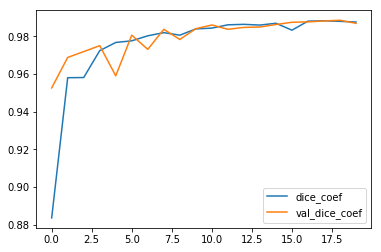

In [19]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=5, verbose=1) #, 
                    #callbacks=[keras_utils.TqdmProgressCallback()])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('naive_model.h5')

# Attempt 2 - Naive with skip connections

Adding in the following elements:
- skip connections
- transposed convolutions instead of upsampling. 
- learning rate decay

In [9]:
from keras.callbacks import LearningRateScheduler
import math

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 1e-3
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

In [10]:
from keras.layers import Input, Dense, Add
from keras.models import Model
from keras.layers.merge import concatenate

# Input
inputs = Input(shape=(320, 480, 3))

# c = convolution, p = pooling, s = adding, u = unpooling

# Encoder
c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
p1 = MaxPooling2D((2, 2), padding='same') (c1)

c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
p2 = MaxPooling2D((2, 2), padding='same') (c2)

c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
p3 = MaxPooling2D((2, 2), padding='same') (c3)

# Decoder with skip connections
c4 = Conv2D(64, 3, activation='relu', padding='same')(p3)
u1 = Conv2DTranspose (64, (2, 2), strides=(2, 2), padding='same') (c4)
s1 = concatenate([u1, c3])

c5 = Conv2D(32, 3, activation='relu', padding='same')(u1)
s2 = concatenate([c5, p2])
u2 = Conv2DTranspose (32, (2, 2), strides=(2, 2), padding='same') (s2)

c6 = Conv2D(16, 3, activation='relu', padding='same')(u2)
s3 = concatenate([c6, p1])
u3 = Conv2DTranspose (16, (2, 2), strides=(2, 2), padding='same') (s3)

c7 = Conv2D(16, 3, activation='relu', padding='same') (u3)

final = Conv2D(1, 1, activation='sigmoid', padding='same')(c7)

model = Model(inputs=inputs, outputs=final)

# This creates a model that includes
# the Input layer and intermediate layers

model.compile(Adam(1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 320, 480, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 160, 240, 16) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 160, 240, 32) 4640        max_pooling2d_4[0][0]            
__________________________________________________________________________________________________
max_poolin

Train on 4070 samples, validate on 1018 samples
Epoch 1/20
 - 84s - loss: -8.0072e-01 - acc: 0.9546 - dice_coef: 0.8706 - val_loss: -8.7479e-01 - val_acc: 0.9713 - val_dice_coef: 0.9158
Epoch 2/20
 - 81s - loss: -9.2986e-01 - acc: 0.9831 - dice_coef: 0.9559 - val_loss: -9.5054e-01 - val_acc: 0.9875 - val_dice_coef: 0.9691
Epoch 3/20
 - 81s - loss: -9.5464e-01 - acc: 0.9887 - dice_coef: 0.9715 - val_loss: -9.5583e-01 - val_acc: 0.9888 - val_dice_coef: 0.9724
Epoch 4/20
 - 81s - loss: -9.6274e-01 - acc: 0.9905 - dice_coef: 0.9766 - val_loss: -9.6777e-01 - val_acc: 0.9915 - val_dice_coef: 0.9795
Epoch 5/20
 - 82s - loss: -9.7182e-01 - acc: 0.9926 - dice_coef: 0.9821 - val_loss: -9.6566e-01 - val_acc: 0.9910 - val_dice_coef: 0.9788
Epoch 6/20
 - 81s - loss: -9.7411e-01 - acc: 0.9931 - dice_coef: 0.9836 - val_loss: -9.6947e-01 - val_acc: 0.9919 - val_dice_coef: 0.9807
Epoch 7/20
 - 81s - loss: -9.7508e-01 - acc: 0.9934 - dice_coef: 0.9842 - val_loss: -9.7432e-01 - val_acc: 0.9931 - val_dice

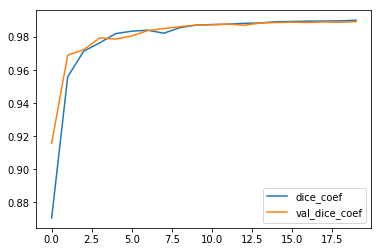

In [26]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=5, verbose=2, 
                   callbacks=[lrate])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('naive_skip_model.h5')

# Attempt 3 - UNet implementation

Added:
- Dropout
- More layers
- Data augmentation

In [36]:
inputs = Input((320, 480, 3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=inputs, outputs=outputs)
model.compile(Adam(1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 320, 480, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
dropout_64 (Dropout)            (None, 320, 480, 16) 0           conv2d_156[0][0]                 
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 320, 480, 16) 2320        dropout_64[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [144]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 2

# we create two instances with the same arguments
data_gen_args = dict(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# seed = 1
# image_datagen.fit(X_train, augment=True, seed=seed)
# mask_datagen.fit(y_train, augment=True, seed=seed)

# Need to set the same seed for both image and mask generator
image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed = 42)
mask_generator = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed = 42)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [38]:
history = model.fit_generator(train_generator,steps_per_epoch=len(X_train) / BATCH_SIZE, 
                              epochs=30, validation_data=(X_val, y_val), verbose=2, callbacks=[lrate])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('unet_v1.h5')

# model.fit_generator(
#     train_generator,
#     steps_per_epoch=2000,
#     epochs=50)

Epoch 1/30
 - 304s - loss: -9.5345e-01 - acc: 0.9843 - dice_coef: 0.9706 - val_loss: -9.5422e-01 - val_acc: 0.9889 - val_dice_coef: 0.9736
Epoch 2/30
 - 303s - loss: -9.6858e-01 - acc: 0.9876 - dice_coef: 0.9804 - val_loss: -9.7422e-01 - val_acc: 0.9931 - val_dice_coef: 0.9846
Epoch 3/30
 - 303s - loss: -9.7396e-01 - acc: 0.9887 - dice_coef: 0.9837 - val_loss: -9.8113e-01 - val_acc: 0.9948 - val_dice_coef: 0.9879
Epoch 4/30
 - 303s - loss: -9.7988e-01 - acc: 0.9899 - dice_coef: 0.9872 - val_loss: -9.8465e-01 - val_acc: 0.9956 - val_dice_coef: 0.9900
Epoch 5/30
 - 303s - loss: -9.7789e-01 - acc: 0.9895 - dice_coef: 0.9862 - val_loss: -9.8322e-01 - val_acc: 0.9952 - val_dice_coef: 0.9894
Epoch 6/30
 - 303s - loss: -9.8243e-01 - acc: 0.9903 - dice_coef: 0.9888 - val_loss: -9.8459e-01 - val_acc: 0.9955 - val_dice_coef: 0.9903
Epoch 7/30
 - 303s - loss: -9.8359e-01 - acc: 0.9905 - dice_coef: 0.9895 - val_loss: -9.8699e-01 - val_acc: 0.9961 - val_dice_coef: 0.9917
Epoch 8/30
 - 303s - loss: 

KeyboardInterrupt: 

# Attempt 4 - Pretrained with VGG16

In [12]:
from keras.applications import VGG16

inputs = Input((320, 480, 3))

vgg16 = VGG16(include_top=False, input_tensor=inputs)

#vgg16.summary()

58892288/58889256 [==============================] - 10s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 320, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 240, 128)     147584    
_________________________________________________________________
block2_poo

In [73]:
from keras.layers import Convolution2D

inputs = Input((320, 480, 3))

# Defining the VGG architecture so I can use the functional API. 

# This is the ENCODER and it is not trainable. 

block1_conv1 = Convolution2D(64, (3, 3), activation='relu', padding='same', name="block1_conv1")     (inputs)
block1_conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same', name="block1_conv2")     (block1_conv1)
block1_pool = MaxPooling2D((2,2), name="block1_pool")             (block1_conv2)

block2_conv1 = Convolution2D(128, (3, 3), activation='relu', padding='same', name="block2_conv1")    (block1_pool)
block2_conv2 = Convolution2D(128, (3, 3), activation='relu', padding='same', name="block2_conv2")    (block2_conv1)
block2_pool = MaxPooling2D((2,2), name="block2_pool")             (block2_conv2)

block3_conv1 = Convolution2D(256, (3, 3), activation='relu', padding='same', name="block3_conv1")    (block2_pool)
block3_conv2 = Convolution2D(256, (3, 3), activation='relu', padding='same', name="block3_conv2")    (block3_conv1)
block3_conv3 = Convolution2D(256, (3, 3), activation='relu', padding='same', name="block3_conv3")    (block3_conv2)
block3_pool = MaxPooling2D((2,2), name="block3_pool")             (block3_conv3)

block4_conv1 = Convolution2D(512, (3, 3), activation='relu', padding='same', name="block4_conv1")    (block3_pool)
block4_conv2 = Convolution2D(512, (3, 3), activation='relu', padding='same', name="block4_conv2")    (block4_conv1)
block4_conv3 = Convolution2D(512, (3, 3), activation='relu', padding='same', name="block4_conv3")    (block4_conv2)
block4_pool = MaxPooling2D((2,2), name="block4_pool")             (block4_conv3)

block5_conv1 = Convolution2D(512, (3, 3), activation='relu', padding='same', name="block5_conv1")    (block4_pool)
block5_conv2 = Convolution2D(512, (3, 3), activation='relu', padding='same', name="block5_conv2")    (block5_conv1)
block5_conv3 = Convolution2D(512, (3, 3), activation='relu', padding='same', name="block5_conv3")    (block5_conv2)
block5_pool = MaxPooling2D((2,2), name="block5_pool")             (block5_conv3)

# This is the DECODER and it is trainable. 

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (block5_pool)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, block4_pool])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, block3_pool])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, block2_pool])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, block1_pool], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (u10)

unet_pretrained= Model(input=inputs, outputs=outputs)

# Setting the weights for the encoder based on VGG
for layer in vgg16.layers[1:-1]:
    layer_new = unet_pretrained.get_layer(layer.name)
    layer_new.set_weights(layer.get_weights())
    layer_new.trainable = False

unet_pretrained.compile(Adam(1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])
unet_pretrained.summary()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 480, 64) 1792        input_40[0][0]                   
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

Epoch 1/20
 - 385s - loss: -9.7234e-01 - acc: 0.9885 - dice_coef: 0.9825 - val_loss: -9.8333e-01 - val_acc: 0.9953 - val_dice_coef: 0.9889
Epoch 2/20
 - 384s - loss: -9.8112e-01 - acc: 0.9902 - dice_coef: 0.9878 - val_loss: -9.8514e-01 - val_acc: 0.9957 - val_dice_coef: 0.9902
Epoch 3/20
 - 384s - loss: -9.8070e-01 - acc: 0.9901 - dice_coef: 0.9877 - val_loss: -9.8386e-01 - val_acc: 0.9954 - val_dice_coef: 0.9896
Epoch 4/20
 - 384s - loss: -9.8262e-01 - acc: 0.9904 - dice_coef: 0.9888 - val_loss: -9.8659e-01 - val_acc: 0.9960 - val_dice_coef: 0.9911
Epoch 5/20
 - 384s - loss: -9.8465e-01 - acc: 0.9908 - dice_coef: 0.9901 - val_loss: -9.8808e-01 - val_acc: 0.9964 - val_dice_coef: 0.9919
Epoch 6/20
 - 384s - loss: -9.8499e-01 - acc: 0.9908 - dice_coef: 0.9903 - val_loss: -9.8724e-01 - val_acc: 0.9962 - val_dice_coef: 0.9913
Epoch 7/20
 - 384s - loss: -9.8527e-01 - acc: 0.9909 - dice_coef: 0.9904 - val_loss: -9.8888e-01 - val_acc: 0.9965 - val_dice_coef: 0.9925
Epoch 8/20
 - 384s - loss: 

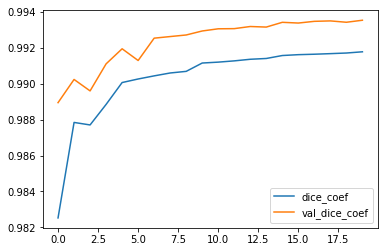

In [70]:
history = unet_pretrained.fit_generator(train_generator,steps_per_epoch=len(X_train) / BATCH_SIZE, 
                              epochs=20, validation_data=(X_val, y_val), verbose=2, callbacks=[lrate])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('unet_pretrained.h5')

# Attempt 5 - Unsupervised pretraining

Since the test set is so large, we'll pretrain an autoencoder on the whole test set, then use the encoder as part of a segmentation model. This means that we will train in two phases. 

In [ ]:
fom keras.models import Model
model = Model(input = autoencoder.layers[0].input, output = autoencoder.layers[4].output)

In [127]:
inputs = Input((320, 480, 3))

# This is the encoder

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# Dense layer with 1024 features
d1 = Dense(2048, activation='elu') (c5)

# This is the decoder

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (d1)
#u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
#u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
#u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
#u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Need three channels
final = Conv2D(3, (1, 1), activation='sigmoid') (c9)

autoencoder = Model(inputs, final)
autoencoder.compile(Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 320, 480, 3)       0         
_________________________________________________________________
conv2d_351 (Conv2D)          (None, 320, 480, 16)      448       
_________________________________________________________________
dropout_114 (Dropout)        (None, 320, 480, 16)      0         
_________________________________________________________________
conv2d_352 (Conv2D)          (None, 320, 480, 16)      2320      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 160, 240, 16)      0         
_________________________________________________________________
conv2d_353 (Conv2D)          (None, 160, 240, 32)      4640      
_________________________________________________________________
dropout_115 (Dropout)        (None, 160, 240, 32)      0         
__________

### Pretraining

In [130]:
BATCH_SIZE = 8

train_data_dir = 'input/test'
validation_data_dir = 'input/train'

train_datagen = ImageDataGenerator(
        rescale=1./255)#,
#         rotation_range=5,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
#         horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(320, 480),
        batch_size=BATCH_SIZE,
        class_mode='input',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(320, 480),
        batch_size=BATCH_SIZE,
        class_mode='input')


history = autoencoder.fit_generator(
        train_generator,
        steps_per_epoch= 2000, #len(ids_test)*16 / BATCH_SIZE,
        epochs=1,
        #validation_data=validation_generator,
        #validation_steps=len(X_train) / BATCH_SIZE, 
        verbose=1, 
        callbacks=[lrate])
    
autoencoder.save('unet_autoencoder.h5')

Found 100064 images belonging to 1 classes.
Found 5088 images belonging to 1 classes.
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.4592

KeyboardInterrupt: 

Text(0.5,1,'y_pred')

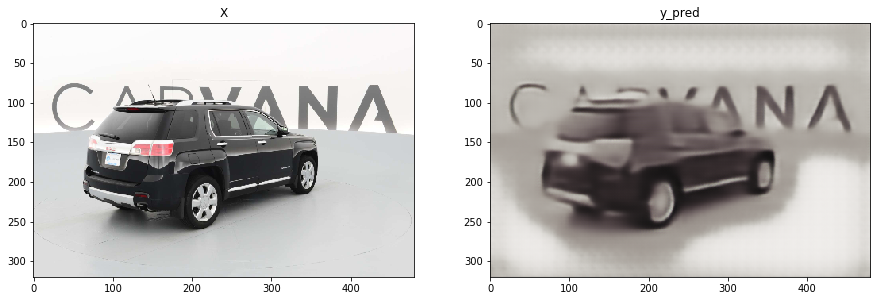

In [131]:
load_img_special = lambda im, idx: imread(join(input_folder, 'test/test', '{}_{:02d}.jpg'.format(im, idx)))

X = downscale(load_img_special(ids_test[4000], 11)) / 255.

fig, ax = plt.subplots(1,2, figsize=(15,10))
ax = ax.ravel()

ax[-2].imshow(X)
ax[-2].set_title('X')

y_pred = autoencoder.predict(X[None])
ax[-1].imshow(y_pred.squeeze())
ax[-1].set_title('y_pred')

### Actual training

In [ ]:
decoder_input = Input((20, 30, 2048))

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (decoder_input)
#u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
#u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
#u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
#u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Only one channel, because it's  a binary segmentation task. 
final_decoder = Conv2D(1, (1, 1), activation='sigmoid') (c9)

decoder = Model(input = decoder_input, output = final_decoder)

final_encoder = autoencoder.get_layer(index=20).output
full_output = decoder(final_encoder)
full_model  = Model(inputs=autoencoder.input, outputs=full_output)

full_model.summary()
full_model.compile(Adam(1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])

In [ ]:
## Need to reset the train_generator

BATCH_SIZE = 2

# we create two instances with the same arguments
data_gen_args = dict(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Need to set the same seed for both image and mask generator
image_generator = image_datagen.flow(X_train, batch_size=BATCH_SIZE, seed = 42)
mask_generator = mask_datagen.flow(y_train, batch_size=BATCH_SIZE, seed = 42)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

In [ ]:
history = full_model.fit_generator(train_generator,steps_per_epoch=len(X_train) / BATCH_SIZE, 
                              epochs=10, validation_data=(X_val, y_val), verbose=1, callbacks=[lrate])
    
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save('unet_autoencoder.h5')

Epoch 1/20
2290/2289 [==============================] - 305s 133ms/step - loss: -0.9357 - acc: 0.9805 - dice_coef: 0.9597 - val_loss: -0.9432 - val_acc: 0.9856 - val_dice_coef: 0.9640
Epoch 2/20
2290/2289 [==============================] - 303s 133ms/step - loss: -0.9568 - acc: 0.9851 - dice_coef: 0.9723 - val_loss: -0.9662 - val_acc: 0.9911 - val_dice_coef: 0.9784
Epoch 3/20
2290/2289 [==============================] - 303s 132ms/step - loss: -0.9621 - acc: 0.9863 - dice_coef: 0.9758 - val_loss: -0.9620 - val_acc: 0.9903 - val_dice_coef: 0.9757
Epoch 4/20
2290/2289 [==============================] - 302s 132ms/step - loss: -0.9664 - acc: 0.9872 - dice_coef: 0.9785 - val_loss: -0.9731 - val_acc: 0.9928 - val_dice_coef: 0.9821
Epoch 5/20
2290/2289 [==============================] - 302s 132ms/step - loss: -0.9735 - acc: 0.9887 - dice_coef: 0.9829 - val_loss: -0.9767 - val_acc: 0.9936 - val_dice_coef: 0.9846
Epoch 6/20
2290/2289 [==============================] - 302s 132ms/step - loss: 

# Submission

In [ ]:
2+2

In [41]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    # We avoid issues with '1' at the start or end (at the corners of 
    # the original image) by setting those pixels to '0' explicitly.
    # We do not expect these to be non-zero for an accurate mask, 
    # so this should not harm the score.
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

Text(0.5,1,'y_pred (test set) - final')

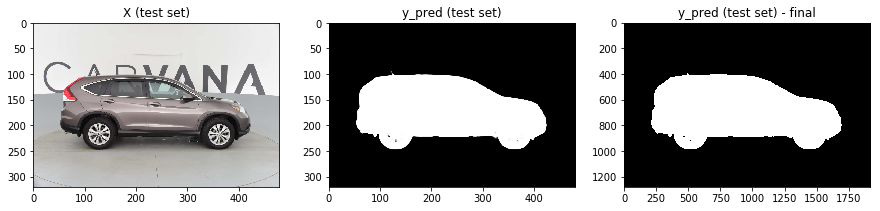

In [42]:
def prepare_img(im, idx):
    
    return (downscale(load_test_img(im, idx)) / 255.)
 
def predict_img_rle(X):
    y_pred = model.predict(X[None]).squeeze()
    
    # Upscale 4X on each axis
    y_pred = upscale(y_pred)
        
    # Encode a binary version of the image
    return rle_encode(np.float32(np.where(y_pred > 0.5, 1, 0)))

X = prepare_img(ids_test[66], 13)
y_pred = model.predict(X[None]).squeeze()

y_final = predict_img_rle(prepare_img(ids_test[66], 13))
y_final = rle_decode(y_final, (1280, 1918))

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax = ax.ravel()

ax[-3].imshow(X)
ax[-3].set_title('X (test set)')

ax[-2].imshow(y_pred, cmap='gray')
ax[-2].set_title('y_pred (test set)')

ax[-1].imshow(y_final, cmap='gray')
ax[-1].set_title('y_pred (test set) - final')

In [43]:
file = open("unet_v1.csv", "w+")
file.write("img,rle_mask\n")

#num_test = 100
num_test = len(ids_test)

with tqdm_notebook(total=num_test*16) as bar:
    for i in ids_test[:num_test]:
        for j in imgs_idx:
            res = predict_img_rle(prepare_img(i, j))
            file.write('{}_{:02d}.jpg, {}\n'.format(i, j, res))
            bar.update()
            
# For some reason, the last image doesn't always get written, thus we need to flush. 
file.flush()

# Exploration

Text(0.5,1,'y_pred')

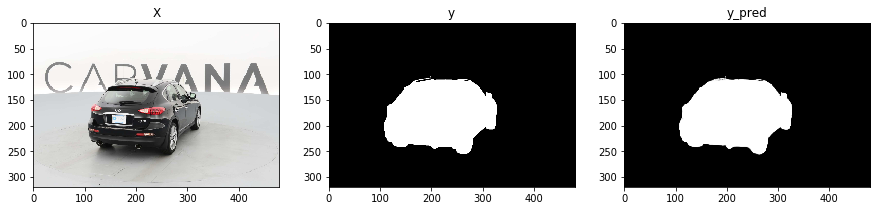

In [40]:
idx = 20
x = X_val[idx]

fig, ax = plt.subplots(1,3, figsize=(15,10))
ax = ax.ravel()

ax[-3].imshow(x)
ax[-3].set_title('X')

ax[-2].imshow(y_val[idx,...,0], cmap='gray')
ax[-2].set_title('y')

y_pred = model.predict(x[None]).squeeze()
ax[-1].imshow(y_pred, cmap='gray')
ax[-1].set_title('y_pred')

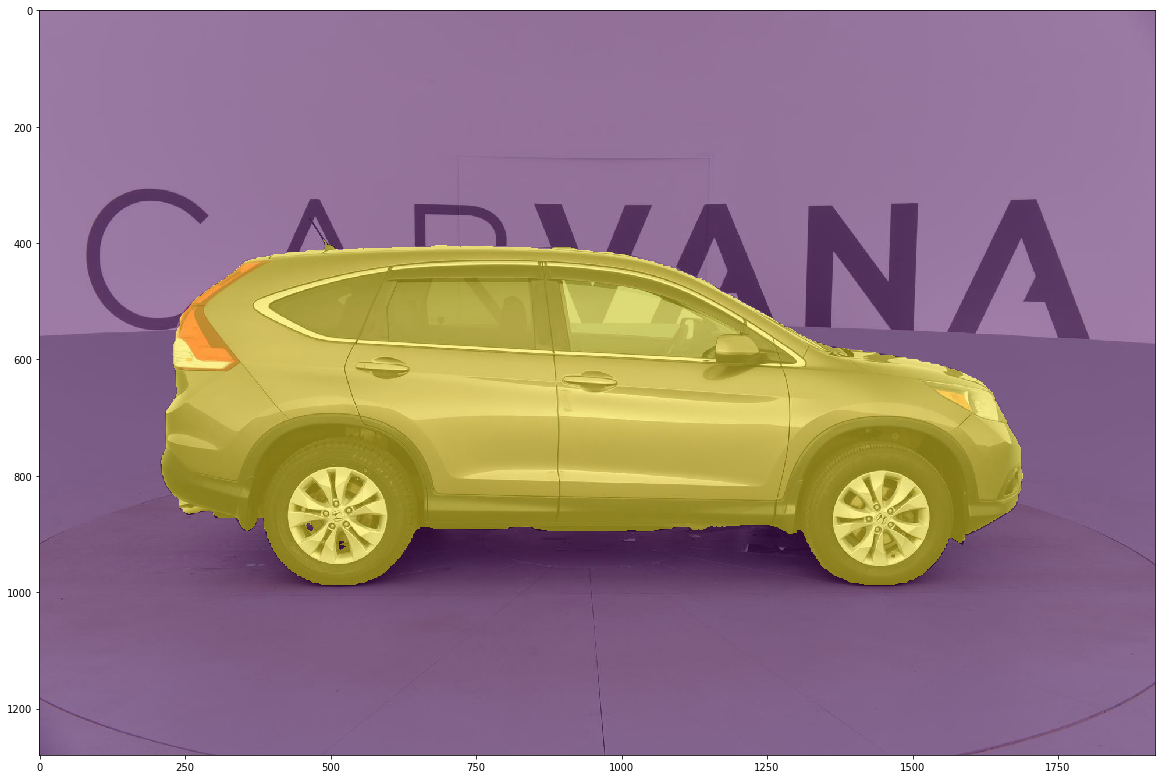

In [45]:
# Let's take a look at an expanded version of one of these

plt.figure(figsize=(20,20))

test = predict_img_rle(X)
plt.imshow(load_test_img(ids_test[66], 13))
plt.imshow(rle_decode(test, (1280, 1918)), alpha = 0.5)

In [ ]:
# We could definintely improve on the resolution, but it looks like it's getting the main outline of the shape. 